# __SpringBoard Mini-Project: Take Home Challenge__
## __Interview Prep__

__Written by: Sofy Weisenberg__<br>
__Date: 04/27/20__



__Data Analysis Interview Challenge__

Ultimate Technologies Inc. is an American worldwide online transportation network company that has disrupted the taxi and logistics industry and is a prestigious company to work at. This challenge has been adapted from an actual Ultimate Inc. data science challenge.

__Part 1 ‑ Exploratory data analysis__

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# Use the current working directory path to navigate to the location of the data
cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, 'logins.json')

# Throw an assert error if the path does not exist
assert os.path.exists(data_path)

In [2]:
logins_df = pd.read_json(data_path)
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


All 93142 entries in this 1D series are non-null. All are of the datetime64[ns] data type.

In [3]:
# get some summary data about the datetimes in the series
logins_df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


One potential issue with the data: the dates refer to 1970, which is prior to the internet age. Since this data represents logins by ***online users***, this year does appear to be correct. There is likely an issue with the date logging or with the conversion to datetimes.

In [4]:
# check if there are any duplicated timestamps. Is it possible more than one person logged in at exactly the same second? 
# probably yes --> not a data issue
logins_df.duplicated().sum()

877

There are 877 duplicated datetime objects (less than 0.1%). This could likely be attributed to users logging in at the same time or the login time being rounded to the nearest second. This number seems plausible. If it were one order of magnitude higher (1%), it might be suspicious and could point to faulty data gathering.

In [5]:
# set the index of the dataframe to be the datetime series
logins_df.index = logins_df['login_time']

# using the new index, group the datet into 15 minute intervals
# start with the quarter hour before the first entry (label='left' arg)
logins_df_15_min = logins_df.groupby(pd.Grouper(freq='15Min', base=15, label='left')).count()
logins_df_15_min

,login_time
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [6]:
# get descriptive statistics summary of login counts grouped by 15 minute intervals
logins_df_15_min.describe()

,login_time
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AD5DE0B708>]],
      dtype=object)

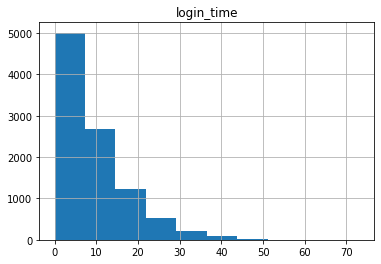

In [7]:
logins_df_15_min.hist()

Text(0, 0.5, 'Login Count')

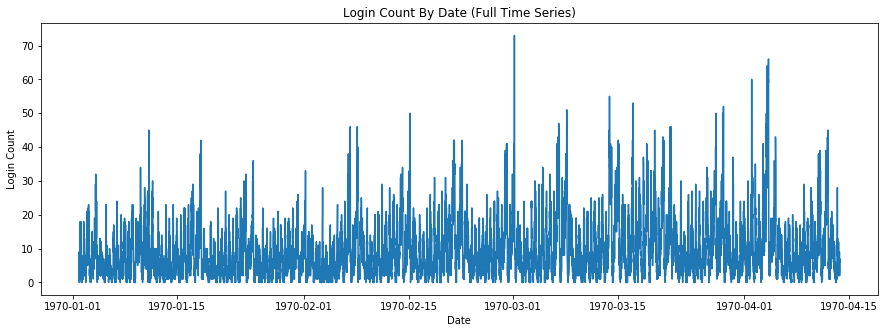

In [8]:
# plot the login counts per 15 minute interval across the entire series
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(logins_df_15_min)
ax.set_title('Login Count By Date (Full Time Series)')
ax.set_xlabel('Date')
ax.set_ylabel('Login Count')

Text(0, 0.5, 'Login Count')

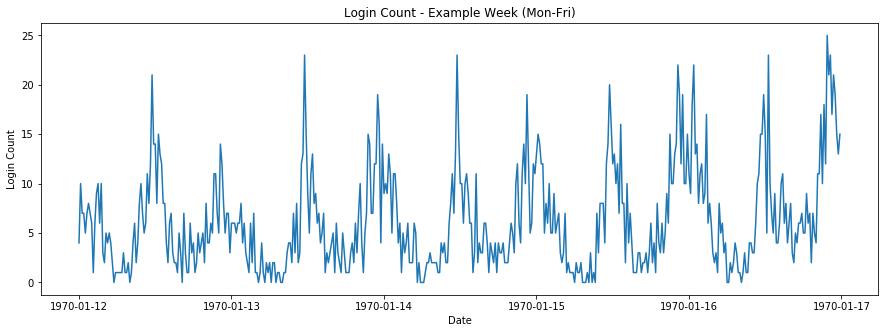

In [9]:
# plot the login counts per 15 minute interval across the entire series
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(logins_df_15_min.loc['1970-01-12':'1970-01-16'])
ax.set_title('Login Count - Example Week (Mon-Fri)')
ax.set_xlabel('Date')
ax.set_ylabel('Login Count')

Text(0, 0.5, 'Login Count')

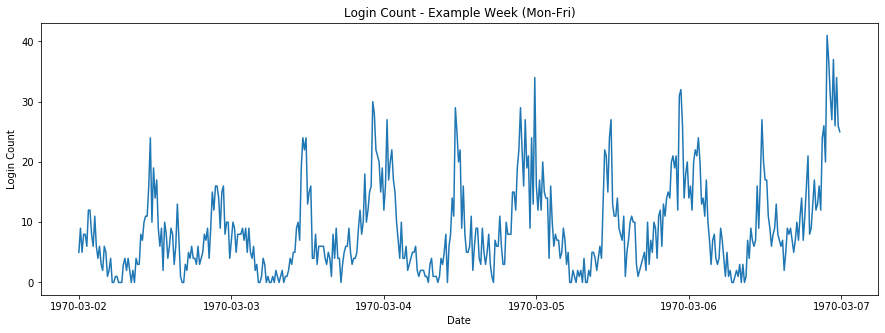

In [10]:
# plot the login counts per 15 minute interval across the entire series
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(logins_df_15_min.loc['1970-03-02':'1970-03-06'])
ax.set_title('Login Count - Example Week (Mon-Fri)')
ax.set_xlabel('Date')
ax.set_ylabel('Login Count')

For Mon-Fri, peaks are regularly observed around mid-day and midnight. The highest peak is Friday night. This makes sense as most taxis are used around lunchtime and at night, particularly on Friday night, during which many people go out for entertainment.

Other than the supposed year of data collection (1970), there do not appear to be any data quality issues. The data range and values seem plausible across all of the logged days and appear to follow a predictable daily/weekly demand cycle.

__Part 2 ‑ Experiment and metrics design__

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

__Answer 1__<br>

As the primary metric of success for this experiment, I would choose the total profit from all rides during which the driver crossed between cities. The profit would exclude the reimbursement fees. This metric could be collected specifically per peak hour, per day, or per month, depending on the length of the experiment. 

This is because in theory the reason for the toll-reimbursement incentive is to provide more availability of drivers to an under-realized market segment (those needing to travel between cities). The increase in this median number of rides (or lack thereof) would signal that there is a potential for increased ridership and that this potential is (or is not) being tapped by implementing the new reimbursement strategy to an extent that exceeds the cost of the reimbursement itself.

__Answer 2__<br>

The proposed experiment is 4 months long and would require the company to implement the toll reimbursement strategy over the entire duration of the experiment. The first month will allow for the drivers and riders to become familiar with the new reimbursement policy (drivers) and increased availability of cross-city routes (drivers). The subsequent 3 months will be used to gauge the success of the implemented policy by monitoring the chosen metric.

As with any policy change, standard metrics such as overall ridership, overall profits, and median wait times (during peak and off-peak hours) should be monitored for any extreme departure from the acceptable control limits. If at any point during the experiment these metrics fall out of spec, the strategy should be reconsidered and potentially recalled, depending on severity.

__(a)__ The experiment will be preceded by a marketing campaign for riders, as well as policy updates for drivers. Both should be disseminated in the weeks preceding the first month of the experiment. Once the policy is in effect, the first month will be a transition period for adjusting to the new state. It may be that it takes more than a month for the effects of the policy to stabilize, but for the sake of evaluating the effects in a reasonable time frame, one month will be given. 

Then, during the following 3 months, data would be gathered (using existing data infrastructure) on the completed rides between the cities. This could be done practically by filtering all of the rides during this period with a pick-up location in one city and a drop-off location in the other, and vice versa. The profit of the ride, minus the toll reimbursement to the driver, would be calculated for each ride and the total calculated over the entire hour/day/month.

This could then be compared to corresponding data for the previous year (during the same months) and/or for the months just prior to the experiment, and a statistical hypothesis test performed to determine if the profit from this segment of rides increased with statistical significance.

__(b)__ Definitions:

Period A: 3 months just prior to experiment (or corresponding to the same months of the experiment from the previous year), during which the reimbursement policy is not in effect<br>
Period B: 3 months (after 1 month transition) that the reimbursement policy is in effect

Test metric (X): median hourly total profit from all rides during which the driver crossed between cities during peak hours

A statistical hypothesis test could be formulated as follows:

Ho: The difference of means for X(A) and X(B) is less than or equal to zero.<br>
Ha: The difference of means for X(A) and X(B) is greater than zero.

A one-sided t-test may be performed at 95% significance level to determine if the null hypothesis Ho may be rejected. The total number of observations for the experiment should be enough to satisfy the requirements of normality. If not, a bootstrap approach may be used to resample the distributions X(A) and X(B) and perform the hypothesis test.

The same hypothesis test may be repeated for X during off-peak hours. Peak/off-peak can be defined beforehand as having certain threshold of total ridership across both cities.

__(c)__ The results of the hypothesis would need to be interpreted within the context of the other monitored metrics (overall ridership, overall profits, and median wait times). Confounding factors should be taken into account in this assessment (for example, changes during holidays, etc.)
- If the p-value showed extreme effectiveness of the policy (p << 0.05), and there was little or positive movement in the other major metrics, then the policy should be continued.
- If the p-value showed extreme effectiveness of the policy (p << 0.05), but there was significant negative movement in any of the metrics, the policy should be reexamined and potentially discontinued. Alternatively, more drivers could be hired to fill in the gap and take advantage of the new revenue stream, if this is fiscally possible. 
- If the p-value showed little to no effectiveness of the policy (p ~ 0.05 or p > 0.05), then the policy should be discontinued.

__Part 3 ‑ Predictive modeling__

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

Data description: <br>

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

__Answer 1__

In [11]:
# Use the current working directory path to navigate to the location of the data
cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, 'ultimate_data_challenge.json')

# Throw an assert error if the path does not exist
assert os.path.exists(data_path)

udc_df = pd.read_json(data_path)
udc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [12]:
# get summary statistics for all float64 type columns. All other columns will be calculated separately (see below)
udc_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [13]:
udc_df['city'].describe()

count          50000
unique             3
top       Winterfell
freq           23336
Name: city, dtype: object

In [14]:
udc_df['ultimate_black_user'].describe()

count     50000
unique        2
top       False
freq      31146
Name: ultimate_black_user, dtype: object

In [15]:
udc_df['phone'].describe()

count      49604
unique         2
top       iPhone
freq       34582
Name: phone, dtype: object

In [16]:
udc_df['signup_date'] = pd.to_datetime(udc_df['signup_date'])
udc_df['signup_date'].describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [17]:
udc_df['last_trip_date'] = pd.to_datetime(udc_df['last_trip_date'])
udc_df['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Using the describe() and info() methods on the dataframe, it appears that most of the data is non-null (only 3 columns have null values: 'avg_rating_of_driver', 'phone', and 'avg_rating_of_driver' with 0.4%, 0.8%, and 16% of values missing respectively) and have plausible ranges of values with few outliers.

The small percent of missing values may be imputed with the median value for their respective categories.

In [18]:
# impute missing values with median (only for float types, 'phone' missing values will be imputed separately next)
udc_df_imputed = udc_df.fillna(udc_df.median())

In [19]:
# it makes sense to use the most frequent phone type by city to impute the "phone" missing values.

for index, row in udc_df_imputed.iterrows():
    if (udc_df_imputed['phone'].iloc[index] == None):
        city = udc_df_imputed.city[index]
        phone_by_city = udc_df_imputed.phone[udc_df_imputed.city == city].value_counts().idxmax()
        udc_df_imputed['phone'].iloc[index] = phone_by_city

C:\Users\Niv\Anaconda3\envs\tf_keras_gpu\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [20]:
# check imputed dataframe now contains no null values.
assert(udc_df_imputed.isnull().sum().sum() == 0)

There are now no missing values in the dataset. Now the fraction of retained users will be calculated.

In [21]:
# create a new column of days the user has been "retained"
udc_df_imputed['retention_duration'] = udc_df_imputed['last_trip_date'] - udc_df_imputed['signup_date']
udc_df_imputed['retention_duration'].describe()

count                      50000
mean     92 days 18:57:44.640000
std      62 days 03:06:56.580842
min              0 days 00:00:00
25%             27 days 00:00:00
50%            110 days 00:00:00
75%            150 days 00:00:00
max            181 days 00:00:00
Name: retention_duration, dtype: object

In [22]:
# create a new column of days since last trip, at the data pull date (assumed to be 2014-07-01)
udc_df_imputed['days_since_last_trip'] = udc_df_imputed['last_trip_date'].max() - udc_df_imputed['last_trip_date']
udc_df_imputed['days_since_last_trip'].describe()

count                      50000
mean     72 days 15:57:55.008000
std      61 days 17:15:20.288309
min              0 days 00:00:00
25%             13 days 00:00:00
50%             54 days 00:00:00
75%            137 days 00:00:00
max            181 days 00:00:00
Name: days_since_last_trip, dtype: object

In [23]:
# count the number of users that have made a trip in the 30 days prior to the data pull date (assumed to be 2014-07-01)
retained_user_count = udc_df_imputed['days_since_last_trip'][udc_df_imputed['days_since_last_trip'] < pd.Timedelta(30,'D')].count()

# get the fraction of retained users at the data pull date (assumed to be 2014-07-01)
retained_user_fraction = retained_user_count/udc_df_imputed.shape[0]

print("The fraction of retained users at the data pull date (assumed to be 2014-07-01) is " + str(retained_user_fraction))

The fraction of retained users at the data pull date (assumed to be 2014-07-01) is 0.3662


__Answer 2__

Selecting a model:

The problem statement is to create a predictive model for classifying a given customer as 'retained' or 'not retained' 6 months after signing up for the service. This requires a binary classification model and can be implemented using a machine learning algorithm. Since data on the 6-month retention class of each user is available in the dataset at the data pull date (assumed to be 2014-07-01), the model can be supervised (learn from labeled data).

Based on the need for interpretability of the predictive model, a traditional machine learning approach would likely be more suitable than a neural network. The low number of features in the data also indicate that methods such as linear or logistic regression or simple decision trees could be effective.

Prior to implementing the machine learning model, a Multivariate Analysis of Variance (MANOVA) may be executed to determine the strength of the linear correlation of each of the features to the class label (retained vs. not retained) and to each other. 

Preprocessing:

The datetime features ('signup_date', 'last_trip_date') were used to create 2 new features in the previous section: 'retention_duration', 'days_since_last_trip'. These new features effectively capture the information contained in the original features, but allow it to be numerical (int, number of days) rather than datetime. Therefore the 2 original features will be dropped. The new features are directly correlated to the class, so they will be dropped as well. The feature 'days_since_last_trip' will also be used to generate class labels (since all users in the set joined in January 2014, those who have days_since_last_trip less than 30 days at the data pull date 2014-07-01 will be in the 'retained' class).

Then, all categorical features ('city', 'phone') must first be transformed into numerical features. This can be done using the one-hot encoding method, creating a 'dummy' binary (0/1) feature for each possible value in a category. This increases the number of features, but given the limited scope of this dataset (3 cities, 2 phone types), this number of features will still be low enough that the machine learning methods mentioned above can be implemented effectively.

Lastly the data will be scaled to the [0,1] range in order to make it appropriate for various traditional machine learning classifiers that are based on Euclidean distance.


In [39]:
# class labels column will be used for training/testing later on 
y_bool = udc_df_imputed['days_since_last_trip'] < pd.Timedelta(30,'D')
y = y_bool.astype(int)


# drop datetime features, make bool feature int type
udc_df_reduced = udc_df_imputed.drop(['signup_date', 'last_trip_date','retention_duration','days_since_last_trip'], axis = 1)
udc_df_reduced.ultimate_black_user = udc_df_reduced.ultimate_black_user.astype(int)

udc_df_reduced.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,4.7,1.10,iPhone,15.4,1,46.2,3.67,5.0
1,Astapor,0,5.0,1.00,Android,0.0,0,50.0,8.26,5.0
2,Astapor,3,4.3,1.00,iPhone,0.0,0,100.0,0.77,5.0
3,King's Landing,9,4.6,1.14,iPhone,20.0,1,80.0,2.36,4.9
4,Winterfell,14,4.4,1.19,Android,11.8,0,82.4,3.13,4.9


In [49]:
# create dummy variables for categorical features and drop original feature columns
udc_df_1cat_enc = udc_df_reduced.drop(['city'], axis=1).join(pd.get_dummies(udc_df_reduced['city'],prefix='city')).drop("city_King's Landing",axis =1 )
udc_df_2cat_enc = udc_df_1cat_enc.drop(['phone'], axis=1).join(pd.get_dummies(udc_df_reduced['phone'],prefix='phone',drop_first=True))
udc_df_2cat_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   surge_pct               50000 non-null  float64
 4   ultimate_black_user     50000 non-null  int32  
 5   weekday_pct             50000 non-null  float64
 6   avg_dist                50000 non-null  float64
 7   avg_rating_by_driver    50000 non-null  float64
 8   city_Astapor            50000 non-null  uint8  
 9   city_Winterfell         50000 non-null  uint8  
 10  phone_iPhone            50000 non-null  uint8  
dtypes: float64(6), int32(1), int64(1), uint8(3)
memory usage: 3.0 MB


A total of 3 new features were added and 2 were removed in the categorical feature transformation. With the removal of the 2 datetime features, there are now a total of 11 features. All features are now of numeric types acceptable by machine learning algorithms.

In [50]:
# scale the data to [0,1] range
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(udc_df_2cat_enc)

(50000, 11)

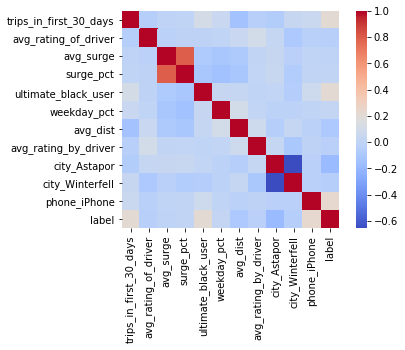

In [52]:
# calculate correlation matrix and plot heatmaps
udc_df_labeled = pd.DataFrame(X, columns=udc_df_2cat_enc.columns)
udc_df_labeled['label'] = y

corrmat = udc_df_labeled.corr()

sns.heatmap(corrmat, vmax=1., square=True, cmap = 'coolwarm')

In [55]:
from statsmodels.multivariate.manova import MANOVA
maov = MANOVA.from_formula("trips_in_first_30_days + avg_rating_of_driver + avg_surge + \
                            surge_pct + ultimate_black_user + weekday_pct + \
                            avg_dist + avg_rating_by_driver + city_Astapor + city_Winterfell + \
                            phone_iPhone  ~ label", data=udc_df_labeled)
print(maov.mv_test())

                      Multivariate linear model
                                                                      
----------------------------------------------------------------------
       Intercept         Value    Num DF   Den DF     F Value   Pr > F
----------------------------------------------------------------------
          Wilks' lambda   0.0065 11.0000 49988.0000 699436.9812 0.0000
         Pillai's trace   0.9935 11.0000 49988.0000 699436.9812 0.0000
 Hotelling-Lawley trace 153.9131 11.0000 49988.0000 699436.9812 0.0000
    Roy's greatest root 153.9131 11.0000 49988.0000 699436.9812 0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
             label          Value   Num DF   Den DF    F Value  Pr > F
----------------------------------------------------------------------
              Wilks' lambda 0

The above MANOVA result suggests that the classes are indeed linearly separable (p values << 0.01), making this dataset a good candidate for logistic regression. None of the features appears to have an immediately apparent strong linear correlation coefficient to the class, but the interdependence of the features should become apparent through the logistic regression model.

Implementing Logistic Regression Model

Now the Logistic Regression model may be fit to the data. The data will be split into training and test sets so that model performance may be evaluated after training. Several commonly tuned hyperparameters will be optimized and a 5-fold cross-validation scheme used to subsample the training set to find the best-performing parameter set. 

Since this is an imbalanced data set (only 36% are of the positive 'retained' class), the F1 score will be used as the primary performance evaluation metric, taking into consideration both the precision and the recall. The train, test sets will be stratified to equally represent the positive class in training and evaluation.

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

# define default random state so that all future random actions will be repeatable
random_state = np.random.RandomState(0)

#initialize a logistic regression model
logistic = LogisticRegression(random_state=random_state)

# define hyperparameter options
penalty = ['l1', 'l2']
C = [1, 10, 100, 1000, 10000, 100000]
class_weight = [{1:0.3, 0:0.7}, {1:0.5, 0:0.5}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid = GridSearchCV(estimator=logistic,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_result = grid.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_result.best_score_))
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s


Best Score (F1): 0.6280
Best Params:  {'C': 1000, 'class_weight': {1: 0.7, 0: 0.3}, 'penalty': 'l1', 'solver': 'saga'}


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.3s finished


In [74]:
from sklearn.metrics import average_precision_score

model = grid_result.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [83]:
# define function for creating labeled confusion matrix for multiclass identification
def labeled_confusion_mat(true_vector, pred_vector, labels):
    confusion_matrix_labeled = pd.DataFrame(confusion_matrix(true_vector, pred_vector))
    confusion_matrix_labeled.columns = list(labels)
    confusion_matrix_labeled.index = list(labels)
    return confusion_matrix_labeled

In [122]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy
fp_rate = confusion_matrix(y_test, y_pred)[0][1] / (confusion_matrix(y_test, y_pred)[0][0] + confusion_matrix(y_test, y_pred)[0][1])
fn_rate = confusion_matrix(y_test, y_pred)[1][0] / (confusion_matrix(y_test, y_pred)[1][0] + confusion_matrix(y_test, y_pred)[1][1])

# print confusion matrix and classification report for model performance on test set
labels = ['Not Retained 6-mo', 'Retained 6-mo']
print('Confusion matrix for LR model evaluation on test set:\n')
print(labeled_confusion_mat(y_test, y_pred, labels))
print(f'\nOverall error rate is {round(error_rate,2)}.')
print(f'False positive rate is {round(fp_rate,2)}.')
print(f'False negative rate is {round(fn_rate,2)}.')
print('\n\nClassification report for LR model evaluation on test set:\n')
print(classification_report(y_test, y_pred, target_names=labels))

Confusion matrix for LR model evaluation on test set:

                   Not Retained 6-mo  Retained 6-mo
Not Retained 6-mo               5737           3770
Retained 6-mo                   1220           4273

Overall error rate is 0.33.
False positive rate is 0.4.
False negative rate is 0.22.


Classification report for LR model evaluation on test set:

                   precision    recall  f1-score   support

Not Retained 6-mo       0.82      0.60      0.70      9507
    Retained 6-mo       0.53      0.78      0.63      5493

         accuracy                           0.67     15000
        macro avg       0.68      0.69      0.66     15000
     weighted avg       0.72      0.67      0.67     15000



In [119]:
confusion_matrix(y_test, y_pred)[1][0]

1220

Text(0, 0.5, 'Precision')

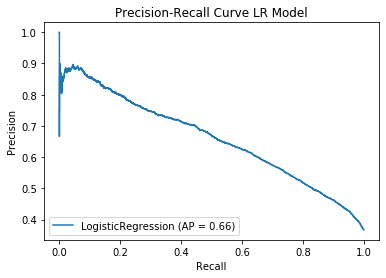

In [130]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(model, X_test,y_test)
plt.title('Precision-Recall Curve LR Model')
plt.xlabel('Recall')
plt.ylabel('Precision')

Using the logistic regression classifier, feature importance can be calculated and used to influence business policy.

Feature: 0, Score: 16.2269, trips_in_first_30_days
Feature: 1, Score: -0.5355, avg_rating_of_driver
Feature: 2, Score: -1.2976, avg_surge
Feature: 3, Score: 0.3172, surge_pct
Feature: 4, Score: 0.8747, ultimate_black_user
Feature: 5, Score: 0.0800, weekday_pct
Feature: 6, Score: -6.1161, avg_dist
Feature: 7, Score: -0.7455, avg_rating_by_driver
Feature: 8, Score: -1.8115, city_Astapor
Feature: 9, Score: -1.2514, city_Winterfell
Feature: 10, Score: 1.1183, phone_iPhone


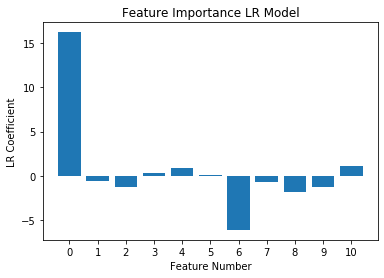

In [136]:
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.4f, ' % (i,v) + list(udc_df_2cat_enc.columns)[i])
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))])
plt.xlabel('Feature Number')
plt.ylabel('LR Coefficient')
plt.title('Feature Importance LR Model')
plt.show()

Seeing that the performance of the Logistic Regression model is somewhat lacking (large misclassification errors), a decision tree classifier may be attempted as well.

In [89]:
from sklearn.tree import DecisionTreeClassifier

#initialize a logistic regression model
clf = DecisionTreeClassifier(random_state=random_state)

# define hyperparameter options
n_components = list(range(1,X.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
param_grid = dict(max_features=n_components,
                  criterion=criterion,
                  max_depth=max_depth)

# scoring is F1 = 2 * (precision * recall) / (precision + recall)
grid_2 = GridSearchCV(estimator=clf,
                    param_grid=param_grid,
                    scoring='f1',
                    verbose=1,
                    n_jobs=-1,
                    cv = StratifiedKFold(n_splits=5, shuffle=True))

grid_2_result = grid_2.fit(X_train, y_train)

print('Best Score (F1): ' '{0:0.4f}'.format(grid_2_result.best_score_))
print('Best Params: ', grid_2_result.best_params_)

Fitting 5 folds for each of 88 candidates, totalling 440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s


Best Score (F1): 0.6784
Best Params:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 7}


[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    3.3s finished


In [94]:
from sklearn.metrics import average_precision_score

model_2 = grid_2_result.best_estimator_
y_pred_2 = model_2.predict(X_test)
y_proba_2 = model_2.predict_proba(X_test)

In [128]:
# calculate error rates
accuracy = accuracy_score(y_test, y_pred_2)
error_rate = 1 - accuracy
fp_rate = confusion_matrix(y_test, y_pred_2)[0][1] / (confusion_matrix(y_test, y_pred_2)[0][0] + confusion_matrix(y_test, y_pred_2)[0][1])
fn_rate = confusion_matrix(y_test, y_pred_2)[1][0] / (confusion_matrix(y_test, y_pred_2)[1][0] + confusion_matrix(y_test, y_pred_2)[1][1])

# print confusion matrix and classification report for model performance on test set
labels = ['Not Retained 6-mo', 'Retained 6-mo']
print('Confusion matrix for DTC model evaluation on test set:\n')
print(labeled_confusion_mat(y_test, y_pred_2, labels))
print(f'\nOverall error rate is {round(error_rate,2)}.')
print(f'False positive rate is {round(fp_rate,2)}.')
print(f'False negative rate is {round(fn_rate,2)}.')
print('\n\nClassification report for DTC model evaluation on test set:\n')
print(classification_report(y_test, y_pred_2, target_names=labels))

Confusion matrix for DTC model evaluation on test set:

                   Not Retained 6-mo  Retained 6-mo
Not Retained 6-mo               8162           1345
Retained 6-mo                   2125           3368

Overall error rate is 0.23.
False positive rate is 0.14.
False negative rate is 0.39.


Classification report for DTC model evaluation on test set:

                   precision    recall  f1-score   support

Not Retained 6-mo       0.79      0.86      0.82      9507
    Retained 6-mo       0.71      0.61      0.66      5493

         accuracy                           0.77     15000
        macro avg       0.75      0.74      0.74     15000
     weighted avg       0.76      0.77      0.76     15000



Text(0, 0.5, 'Precision')

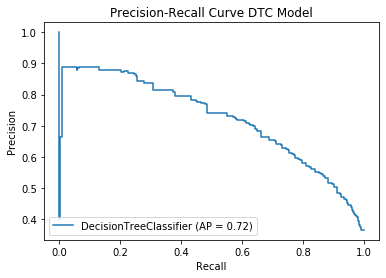

In [129]:
plot_precision_recall_curve(model_2, X_test,y_test)
plt.title('Precision-Recall Curve DTC Model')
plt.xlabel('Recall')
plt.ylabel('Precision')

The decision tree classifier demonstrated better performance on the test set than the logistic regression classifier, with lower error rates across the confusion matrix as well as better precision-recall characteristics (overall better average precision score). Other classification models can be implemented with higher accuracy, but will perhaps be less interpretable. Using the decision tree classifier, feature importance can be calculated and used to influence business policy.

Feature: 0, Score: 0.0310, trips_in_first_30_days
Feature: 1, Score: 0.0073, avg_rating_of_driver
Feature: 2, Score: 0.0550, avg_surge
Feature: 3, Score: 0.0641, surge_pct
Feature: 4, Score: 0.0742, ultimate_black_user
Feature: 5, Score: 0.0677, weekday_pct
Feature: 6, Score: 0.0392, avg_dist
Feature: 7, Score: 0.3822, avg_rating_by_driver
Feature: 8, Score: 0.0921, city_Astapor
Feature: 9, Score: 0.0807, city_Winterfell
Feature: 10, Score: 0.1065, phone_iPhone


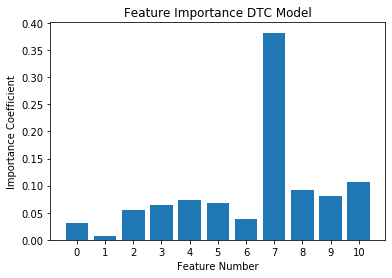

In [137]:
# get importance
importance = model_2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.4f, ' % (i,v) + list(udc_df_2cat_enc.columns)[i])
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xticks([x for x in range(len(importance))])
plt.xlabel('Feature Number')
plt.ylabel('Importance Coefficient')
plt.title('Feature Importance DTC Model')
plt.show()

Interestingly, the DTC model gave very different features of high importance than did the LR model. The take-aways from both models will be discussed in the next section.

__Answer 3__

From the two predictive machine learning classifiers implemented in the previous section, several observations can be made:
- Decision tree modeling is an effective classification method for this data, with relatively low misclassification errors compared to logistic regression; if further accuracy in rider retention is desired, rather than interpretability, decision tree ensemble methods may be pursued (Random Forest, XGBoost)
- From the LR model, though it lacked in accuracy somewhat, feature importance pointed to "trips_in_first_30_days" and "avg_dist" features as those most impactful in the classification of rider retention at the 6 month mark. This prioritization make intuitive sense and a business case should be made to focus on these aspects of rider retention.
- From the DTC model's feature importance, "avg_rating_by_driver" was the feature that stood out the most. This is a surprising result, but could point to an underlying psychological effect that getting feedback from the app/service helps keep ridership engaged and wanting to improve their own "rider score". This effect should not be discounted.

From these observations, a few business suggestions could be made:
- Give incentives/discounts to newly signed riders during their first 30 days. This may "hook" riders onto the service and get them to stay longer.
- Give incentives/discounts for riders taking longer/shorter rides (not clear from the model which end of the "avg_dist" range promotes rider retention). If longer rides promote rider retention, give discounts over X miles traveled. If shorter (more frequent) rides promote retention, give discounts for every Xth ride.
- Improve the app's functionality for driver's to promote them giving scores to their riders for every ride (e.g. bonuses for consistently scoring all riders in a given month). Add additional rider feedback mechanisms/prizes to promote rider engagement with the app (e.g. discounted rides/points for high scores).